### Imports

In [1]:
import numpy as np

import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

from astropy import units as u
from astropy import constants as const
from astropy.table import QTable

from pathlib import Path
import os

import import_ipynb
from Analysis_functions import extract_data, extract_data_short, means_calc, stream_crossing, easy_interpolate, \
     stream_alignment_step1, stream_alignment_step2, stream_shape, binned_relative_difference

from Visualization_functions import snapshots_plot, anim_disc, anim_3d, anim_ComparetoTraceback

sys.path.insert(0, '/home/emelie/Desktop/Codes/PETAR/PeTar-master/tools/')
from analysis import *

importing Jupyter notebook from Analysis_functions.ipynb
importing Jupyter notebook from Visualization_functions.ipynb


In [2]:
plt.rcParams.update({'xtick.labelsize':20, 'ytick.labelsize':20, 'axes.titlesize':26, 
                     'axes.grid':True, 'axes.labelsize':24, 'legend.fontsize':20})

### Core evolution incomplete function

In [3]:
def core_evolution(rmin, rmax, n_shells, in_pos, in_mean_pos, data):
    """
    Parameters:
    -----------
    rmin: int or float
        The minimum considered radius of the core
    
    rmax: int or float
        The maximum considered radius of the core
        
    n_shells: int
        Number of core shells to use to calculate evolution as a function of radius
    
    in_pos: array
        Initial positions of particles in galaxy
        
    in_mean_pos: array
        Initial mean position of galaxy (found in PETAR header)
        
    data: array
        All data for all particles in all snapshots
    ------------------------------------------------------------------------------------
    """
    
    # Centering galaxy in coordinate system using header positions
    centered_data = in_pos - in_mean_pos
    
    # Calculating distance from the center to all particles in galaxy
    r_parts = np.sqrt(np.sum(centered_data**2, axis=1))
    
    # Array of all core radii
    core_radii = np.linspace(rmin, rmax, n_shells)
    
    # Mean core distances for all cores for all snapshots, shape:(n_snapshots, core_radii)
    mean_core_dists = np.empty((len(data[0, 0, :]), len(core_radii)))
    # Mean position of the core for all snapshots, shape:(n_snapshots, 3), 3 = x, y, z
    core_mean_pos = np.empty((len(data[0, 0, :]), 3))
    # shapes: (n_snapshots, n_cores)
    a_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    b_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    c_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    
    # Loops over different core radii, calculations for all snapshots are done in one go
    for i, core_rad in enumerate(core_radii):      
        # Which particles are inside certain radius of core
        core_part_rows = np.where(r_parts<=(core_rad))[0]

        # Extracting core particles' data for all timesteps
        core_parts_all_steps = data[core_part_rows, :, :]
        # Shape (n_core_part, 3, n_snapshots) ##(N, 3, 1) now (N, 3, 40)
        core_pos = core_parts_all_steps[:, 1:4, :] 
        
        
        #print(f'{np.shape(core_pos) = }')
        
        # Calculating mean distances between core particles for all timesteps
        # ----------------------------------------------------------------------------------------------
        pos_diffs = core_pos[:, np.newaxis, :, :] - core_pos[np.newaxis, :, :, :]
        #print(f'{np.shape(pos_diffs) = }')
        
        # Calculates the r-distance between all core particles
        # This gives a double-sided square array divided by the diagonal, which is 0
        # Shape: (n_core_part, n_core_part, n_snapshots)
        pos_dists = np.linalg.norm(pos_diffs, axis=2)
        #print(f'{np.shape(pos_dists) = }')
        
        # Shape: (n_snapshots)
        pos_mean_dists = np.mean(pos_dists[np.triu_indices(len(core_pos), k=1)], axis=0)
        #print(f'{np.shape(pos_mean_dists) = }')
        
        mean_core_dists[:, i] = pos_mean_dists#[:, np.newaxis]
        
        
        
        # Mean core position over time
        # ----------------------------------------------------------------------------------------
        if i==0:
            core_mean_pos[:, :] = np.mean(core_pos, axis=0).T # Should get shape (N_snapshots, 3)
        
        
        
        # Inertia tensor and aspect ratios
        # ---------------------------------------------------------------------------------------------
        #for j in range(len(data[0, 0, :])):
            #print(j)
            # Shape (n_core_part, 1)
            #core_masses = core_parts_all_steps[:, 0, j]
            #print(core_masses)
            #print(np.shape(core_masses))
            #print(np.shape(core_pos[:, :, j]))
            #row, col = np.shape(core_pos[:, :, j])
            #core_pos_tstep = core_pos[:, :, j] #np.reshape(core_pos[:, :, j], (row, col))
            #print(core_pos_tstep)
            #print(np.max(core_pos_tstep[:, 0]) - np.min(core_pos_tstep[:, 0]))
            #print(np.max(core_pos_tstep[:, 1]) - np.min(core_pos_tstep[:, 1]))
            #print(np.max(core_pos_tstep[:, 2]) - np.min(core_pos_tstep[:, 2]))
            #core_in_tensor = inertia_tensor(core_masses, core_pos_tstep)
            #print(core_in_tensor)
            #core_eig_vals, core_eig_vec = np.linalg.eig(core_in_tensor)
            
            
            #fig = plt.figure(figsize=(8, 8))
            #ax = fig.add_subplot(projection='3d')

            #ax.scatter(core_pos_tstep[:, 0], core_pos_tstep[:, 1], core_pos_tstep[:, 2], c='b', s=10)
            #lims = 10
            ##ax.set_xlim(-lims, lims)
            ##ax.set_ylim(-lims, lims)
            ##ax.set_zlim(-lims, lims)
            
            #ax.set_xlabel('x', labelpad=20)
            #ax.set_ylabel('y', labelpad=20)
            #ax.set_zlabel('z', labelpad=20)

            #ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.xaxis.get_major_formatter().set_powerlimits((0, 0))
            #ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.yaxis.get_major_formatter().set_powerlimits((0, 0))
            #ax.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.zaxis.get_major_formatter().set_powerlimits((0, 0))

            #plt.show()

            #eig1 = np.min(core_eig_vals)
            #eig3 = np.max(core_eig_vals)
            #eig2_pos = np.where((core_eig_vals!=np.min(core_eig_vals))&(core_eig_vals!=np.max(core_eig_vals)))[0]
            #eig2 = core_eig_vals[eig2_pos][0]
            #print(eig1, eig2, eig3)
            #print()

            #a_vals[j, i], b_vals[j, i], c_vals[j, i] = aspect_ratios(eig1, eig2, eig3, np.sum(core_masses))
            #print(a_vals[j, i])
            
    
    # Shape (n_snapshots, n_cores, 3)
    #core_aspect_ratios = np.concatenate([a_vals[:, :, np.newaxis], b_vals[:, :, np.newaxis], c_vals[:, :, np.newaxis]], axis=2)
    
    return core_mean_pos, mean_core_dists

# Fiducial model

## Trace back of Boo III Orbit, 3 particles, 1Gyr back in time

In [4]:
fid_trace_back_data, fid_trace_back_header, fid_trace_back_extra, fid_trace_back_hist_data = extract_data(r'btest2_data', r'Petar_back_test2', 125, 1)

print(fid_trace_back_data.shape)
print(fid_trace_back_extra.shape)
print(fid_trace_back_header.shape)

fid_trace_back_halfmass_r = fid_trace_back_extra[0, :]
#print(fid_trace_back_halfmass_r)

print(np.max(fid_trace_back_halfmass_r))
print(np.min(fid_trace_back_halfmass_r))

v_mean_fid_trace_back, r_mean_fid_trace_back = means_calc(fid_trace_back_header)

print(v_mean_fid_trace_back.shape)
print(r_mean_fid_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.014934474300677339
0.0006077755205047432
(126,)
(126,)


## Trace forward of Boo III Orbit, 3 particles, 7Gyr forward in time

In [5]:
fid_trace_forward_data, fid_trace_forward_header, fid_trace_forward_extra, fid_trace_forward_hist_data = extract_data(r'Trace_forward_fiducial_run_data', r'Trace_forward_fiducial_run', 2000, 1)

print(fid_trace_forward_data.shape)
print(fid_trace_forward_extra.shape)
print(fid_trace_forward_header.shape)

fid_trace_forward_halfmass_r = fid_trace_forward_extra[0, :]
#print(fid_trace_forward_halfmass_r)

print(np.max(fid_trace_forward_halfmass_r))
print(np.min(fid_trace_forward_halfmass_r))

v_mean_fid_trace_forward, r_mean_fid_trace_forward = means_calc(fid_trace_forward_header)

print(v_mean_fid_trace_forward.shape)
print(r_mean_fid_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
0.06259852657480973
0.0001785783876411207
(2001,)
(2001,)


## Fiducial model run, large: 997967particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $v_{r} = 197.5 \,$km$\,$s$^{-1}$
- $d = 46.5 \,$kpc
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [6]:
%%time
#fid_mod_data, fid_mod_header, fid_mod_extra, fid_mod_hist_data = extract_data(r'fiducial_large_run_restart', 
#                                                                                          r'Fiducial_large_run', 39, 1)

fid_mod_data, fid_mod_header, fid_mod_extra = extract_data_short(r'fiducial_large_run_restart', 
                                                                 r'Fiducial_large_run', 29)

in_fid_mod_data, in_fid_mod_header, in_fid_mod_extra = extract_data_short(r'fiducial_large_run_restart', 
                                                                 r'Fiducial_large_run', 0)

print(fid_mod_data.shape)
print(fid_mod_extra.shape)
print(fid_mod_header.shape)
print(fid_mod_header[:, -1])

fid_mod_halfmass_r = fid_mod_extra[0, :]
print(fid_mod_halfmass_r)

print(np.max(fid_mod_halfmass_r))
print(np.min(fid_mod_halfmass_r))

v_mean_fid_mod, r_mean_fid_mod = means_calc(fid_mod_header)

print(v_mean_fid_mod.shape)
print(r_mean_fid_mod.shape)

(997967, 21, 1)
(4, 1)
(8, 1)
[ 9.97967000e+05  3.71200000e+03 -3.14424232e+00 -1.33081329e+01
  5.48943838e+00  4.25782666e+01  1.79560627e+02 -3.36702205e+02]
[0.16065999]
0.16065999267433367
0.16065999267433367
(1,)
(1,)
CPU times: user 34.5 s, sys: 1.38 s, total: 35.9 s
Wall time: 35.7 s


###

num_shells = 5
fid_core_mean_pos, fid_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=fid_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=fid_mod_header[2:5, 0], 
                                                       data=fid_mod_data)

print(np.shape(fid_core_mean_pos))
print(np.shape(fid_core_mean_size))

fid_core_mean_r = np.sqrt(np.sum(fid_core_mean_pos**2, axis=1))

figt1, axt1 = plt.subplots(figsize=(8, 6))

tsteps = np.arange(0, 40, 1)*128

axt1.scatter(tsteps, fid_core_mean_r, s=10, c='b')

axt1.set_xlabel('Time [Myr]')
axt1.set_ylabel('Distance to GC [kpc]')

plt.show()

### Plotting snapshots

snapshots = [0, 14, 27, -1]
snapshots_plot(fid_mod_data, snapshots, 25.0e1, 25.0e1, (11, 20), 1, 'Fiducial_model', 
               save=False)

### Plotting trace forward orbit

tff = trace forward fiducial

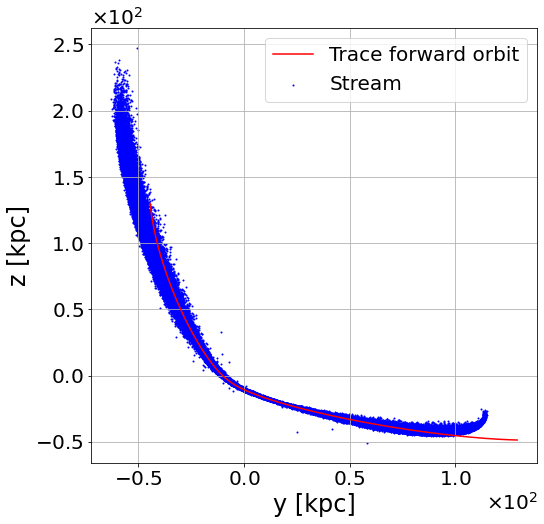

In [7]:
figtff, axtff = plt.subplots(figsize=(8, 8))
#axtff = figtff.add_subplot(projection='3d')

fid_low_tstep = 750
fid_high_tstep = 1135

axtff.plot(fid_trace_forward_data[0, 2, fid_low_tstep:fid_high_tstep], 
           fid_trace_forward_data[0, 3, fid_low_tstep:fid_high_tstep], color='r', label='Trace forward orbit', 
           zorder=10)

axtff.scatter(fid_mod_data[:, 2], fid_mod_data[:, 3], c='b', s=1, zorder=0, label='Stream')


axtff.set_xlabel('y [kpc]') #, labelpad=15)
axtff.set_ylabel('z [kpc]') #, labelpad=15)
#axtff.set_zlabel('z [kpc]', labelpad=5)
axtff.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtff.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtff.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtff.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtff.legend()


#axtff.view_init(4, 15)

plt.show()

### Constructing orbit data array for high $v_r$ model

In [12]:
upper_part_mask = np.where(fid_mod_data[:, 3] == np.max(fid_mod_data[:, 3]))[0]
print(upper_part_mask)
# Position (x, y, z, vx, vy, vz) of highest stream particle
upper_part_pos = fid_mod_data[upper_part_mask, 1:7].flatten() 
print(np.shape(upper_part_pos))
upper_part_pos = np.concatenate([upper_part_pos, [1]])
print(np.shape(upper_part_pos))
# Highest orbit particle is in the first particle I include
# Getting position and velocity of highest orbit particle
upper_orb_part = fid_trace_forward_data[0, 1:7, fid_low_tstep]
upper_orb_part = np.concatenate([upper_orb_part, [1]])
print(np.shape(upper_orb_part))

fid_orbit_pos_extension = np.concatenate([upper_part_pos[np.newaxis, :], upper_orb_part[np.newaxis, :]], 
                                             axis=0)
print(np.shape(fid_orbit_pos_extension))

[645881]
(6,)
(7,)
(7,)
(2, 7)


In [13]:
# Interpolate more points between these two points
for i in range(8):
        #print(i)
        # Roll particles to get x1-x2, x2-x3, etc.
        data_rolled = np.roll(fid_orbit_pos_extension, shift=1, axis=0) 
        
        # Delete first particle because of mismatch: xn-x1
        data = np.delete(fid_orbit_pos_extension, 0, axis=0) 
        data_rolled = np.delete(data_rolled, 0, axis=0)
        #print(data_rolled[:10])
        #print(data[:10])
        
        # Calculating middle point position: x, y, z
        interp_pos = (data_rolled[:, 0:3] + data[:, 0:3])/2 
        
        # Length of data with added points in between
        len_new_data = 2*len(fid_orbit_pos_extension)-1
        #print(len_new_data)

        # x, y, z, vx, vy, vz, t
        new_data = np.zeros((len_new_data, 7))
        
        # Adding data for new points
        new_data[0::2, :] = fid_orbit_pos_extension
        new_data[1::2, 0:3] = interp_pos
        new_data[1::2, 4:] = np.ones((np.shape(new_data[1::2, 4:])))
        
        fid_orbit_pos_extension = new_data
        

In [14]:
print(np.shape(fid_orbit_pos_extension))

(257, 7)


In [15]:
fid_orbit_position = fid_trace_forward_header[2:5, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)
fid_orbit_velocity = fid_trace_forward_header[5:8, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)
fid_orbit_times = fid_trace_forward_header[1, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
fid_orbit_data1 = np.concatenate([fid_orbit_position, fid_orbit_velocity, fid_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(fid_orbit_data1)) # Expect shape n,7


fid_orbit_data = np.concatenate([fid_orbit_pos_extension, fid_orbit_data1], axis=0)
print(np.shape(fid_orbit_data))

(385, 7)
(642, 7)


### Interpolating orbit

In [16]:
interpolated_fid_orbit = easy_interpolate(fid_orbit_data, 2)
print(np.shape(interpolated_fid_orbit))
#print(interpolated_high_vr_orbit[:20, 3:6])

(2565, 8)


<string>:31: RuntimeWarning: divide by zero encountered in true_divide


/tmp/ipykernel_3944243/1464399718.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc)


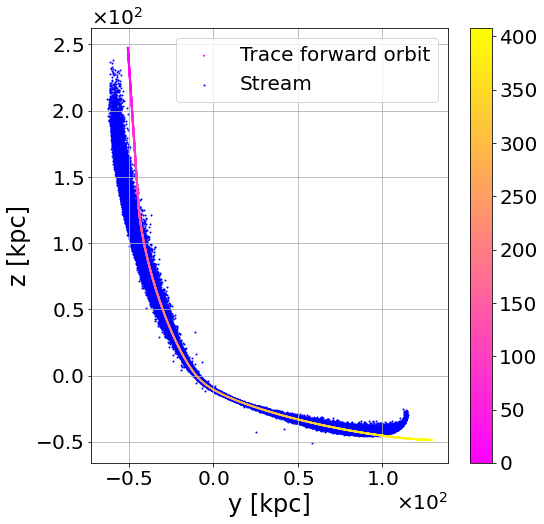

In [17]:
figtff2, axtff2 = plt.subplots(figsize=(8, 8))
#axtff2 = figtfh2.add_subplot(projection='3d')

#axtff2.plot(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], color='r', 
#            label='Trace forward orbit', zorder=10)
sc = axtff2.scatter(interpolated_fid_orbit[:, 1], interpolated_fid_orbit[:, 2], 
                    c=interpolated_fid_orbit[:, -1], cmap='spring', 
                    label='Trace forward orbit', zorder=10, s=1)
plt.colorbar(sc)
axtff2.scatter(fid_mod_data[:, 2], fid_mod_data[:, 3], c='b', s=1, zorder=0, label='Stream')


axtff2.set_xlabel('y [kpc]') #, labelpad=15)
axtff2.set_ylabel('z [kpc]') #, labelpad=15)
#axtff2.set_zlabel('z [kpc]', labelpad=5)
axtff2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtff2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff2.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtff2.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtff2.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtff2.legend()


plt.show()

### Streatching out stream

In [19]:
# Has columns x, y, z, vx, vy, vz
#fid_stream_data = fid_mod_data[:, 1:7, 29]
#fid_orbital_data = np.delete(interpolated_fid_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

In [20]:
#fid_aligned1 = stream_alignment_step1(fid_orbital_data, fid_stream_data)
#print('St1 DONE')
#fid_aligned2 = stream_alignment_step2(fid_orbital_data, fid_aligned1)
#print('St2 DONE')

Differences calculated
St1 DONE


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


St2 DONE


In [21]:
# Saving aligned data
#np.savetxt('Fid_aligned_data_vr.txt', fid_aligned2, delimiter=',')

In [18]:
# Reading in the aligned data from file
fid_aligned_data = np.loadtxt('Fid_aligned_data_vr.txt', delimiter=',')
fid_orbital_data = np.delete(interpolated_fid_orbit, 6, axis=1)

In [19]:
fid_length, fid_width, fid_part_dens = stream_shape(fid_orbital_data, fid_aligned_data)
print('DONE')

DONE


In [25]:
#fid_variance = np.round(np.sum(fid_aligned1[:, -2])/len(fid_aligned1), 2)

#print(fid_variance)

In [20]:
fid_variance =0.49

# High $v_r$ 

## Trace back of Boo III Orbit, 3 particles, 1Gyr back in time

In [21]:
high_vr_trace_back_data, high_vr_trace_back_header, high_vr_trace_back_extra, high_vr_trace_back_hist_data = extract_data(r'Trace_back_high_vr_run_data', r'Trace_back_high_vr', 125, 1)

print(high_vr_trace_back_data.shape)
print(high_vr_trace_back_extra.shape)
print(high_vr_trace_back_header.shape)

high_vr_trace_back_halfmass_r = high_vr_trace_back_extra[0, :]
#print(high_vr_trace_back_halfmass_r)

print(np.max(high_vr_trace_back_halfmass_r))
print(np.min(high_vr_trace_back_halfmass_r))

v_mean_high_vr_trace_back, r_mean_high_vr_trace_back = means_calc(high_vr_trace_back_header)

print(v_mean_high_vr_trace_back.shape)
print(r_mean_high_vr_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.043533689140061
3.978443332717329e-05
(126,)
(126,)


In [14]:
#anim_3d(high_vr_trace_back_data, high_vr_trace_back_header, tstep=8, nsteps=125, lims=15.0e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=10, run='Trace_back_high_vr_run')

## Trace forward of Boo III Orbit, 3 particles, 8Gyr forward in time

In [22]:
high_vr_trace_forward_data, high_vr_trace_forward_header, high_vr_trace_forward_extra, high_vr_trace_forward_hist_data = extract_data(r'Trace_forward_high_vr_run_data', r'Trace_forward_high_vr', 2000, 1)

print(high_vr_trace_forward_data.shape)
print(high_vr_trace_forward_extra.shape)
print(high_vr_trace_forward_header.shape)

high_vr_trace_forward_halfmass_r = high_vr_trace_forward_extra[0, :]
#print(high_vr_trace_forward_halfmass_r)

print(np.max(high_vr_trace_forward_halfmass_r))
print(np.min(high_vr_trace_forward_halfmass_r))

v_mean_high_vr_trace_forward, r_mean_high_vr_trace_forward = means_calc(high_vr_trace_forward_header)

print(v_mean_high_vr_trace_forward.shape)
print(r_mean_high_vr_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
0.15194743234266173
9.209741989690651e-05
(2001,)
(2001,)


In [16]:
#anim_3d(high_vr_trace_forward_data, high_vr_trace_forward_header, tstep=4, nsteps=2000, lims=17.5e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=25, run='Trace_forward_high_vr_run')

## High $v_r$ model run, large: 1000420 particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $v_{r} = 201.3 \,$km$\,$s$^{-1}$
- $d = 46.5 \,$kpc
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [23]:
%%time
#high_vr_mod_data, high_vr_mod_header, high_vr_mod_extra, high_vr_mod_hist_data = extract_data(r'High_vr_run_data', 
#                                                                                          r'High_vr_run', 39, 1)


high_vr_mod_data, high_vr_mod_header, high_vr_mod_extra = extract_data_short(r'High_vr_run_data', 
                                                                             r'High_vr_run', 31)

in_high_vr_mod_data, in_high_vr_mod_header, in_high_vr_mod_extra = extract_data_short(r'High_vr_run_data', 
                                                                             r'High_vr_run', 0)

print(high_vr_mod_data.shape)
print(high_vr_mod_extra.shape)
print(high_vr_mod_header.shape)
print(high_vr_mod_header[:, -1])

high_vr_mod_halfmass_r = high_vr_mod_extra[0, :]
print(high_vr_mod_halfmass_r)

print(np.max(high_vr_mod_halfmass_r))
print(np.min(high_vr_mod_halfmass_r))

v_mean_high_vr_mod, r_mean_high_vr_mod = means_calc(high_vr_mod_header)

print(v_mean_high_vr_mod.shape)
print(r_mean_high_vr_mod.shape)

(1000420, 21, 1)
(4, 1)
(8, 1)
[ 1.00042000e+06  3.96800000e+03 -3.60623254e+00 -1.59237866e+01
  1.12361675e+01  3.33404929e+01  1.47808369e+02 -3.21688510e+02]
[0.16166151]
0.16166150870157894
0.16166150870157894
(1,)
(1,)
CPU times: user 34.5 s, sys: 1.24 s, total: 35.7 s
Wall time: 35.4 s


num_shells = 5
high_vr_core_mean_pos, high_vr_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=high_vr_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=high_vr_mod_header[2:5, 0], 
                                                       data=high_vr_mod_data)

print(np.shape(high_vr_core_mean_pos))
print(np.shape(high_vr_core_mean_size))

high_vr_core_mean_r = np.sqrt(np.sum(high_vr_core_mean_pos**2, axis=1))

figt2, axt2 = plt.subplots(figsize=(8, 6))

tsteps = np.arange(0, 40, 1)*128

axt2.scatter(tsteps, high_vr_core_mean_r, s=10, c='b')

axt2.set_xlabel('Time [Myr]')
axt2.set_ylabel('Distance to GC [kpc]')

plt.show()

###

### Plotting snapshots

snapshots = [0, 14, 27, -1]
snapshots_plot(high_vr_mod_data, snapshots, 25.0e1, 25.0e1, (11, 20), 1, 'High_vr_model', 
               save=False)

### Plotting trace forward orbit

tfh = trace forward high (vr)

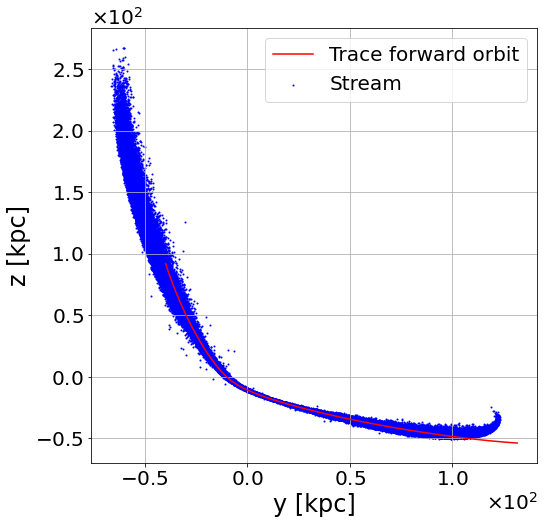

In [24]:
figtfh, axtfh = plt.subplots(figsize=(8, 8))
#axtfh = figtfh.add_subplot(projection='3d')

high_vr_low_tstep = 900 # 650 before
high_vr_high_tstep = 1200

axtfh.plot(high_vr_trace_forward_data[0, 2, high_vr_low_tstep:high_vr_high_tstep], 
           high_vr_trace_forward_data[0, 3, high_vr_low_tstep:high_vr_high_tstep], color='r', 
           label='Trace forward orbit', zorder=10)

axtfh.scatter(high_vr_mod_data[:, 2], high_vr_mod_data[:, 3], c='b', s=1, zorder=0, label='Stream')


axtfh.set_xlabel('y [kpc]') #, labelpad=15)
axtfh.set_ylabel('z [kpc]') #, labelpad=15)
#axtfh.set_zlabel('z [kpc]', labelpad=5)
axtfh.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtfh.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtfh.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtfh.legend()


plt.show()

### Constructing orbit data array for high $v_r$ model

In [25]:
upper_part_mask = np.where(high_vr_mod_data[:, 3] == np.max(high_vr_mod_data[:, 3]))[0]
# Position (x, y, z, vx, vy, vz) of highest stream particle
upper_part_pos = high_vr_mod_data[upper_part_mask, 1:7].flatten() 
upper_part_pos = np.concatenate([upper_part_pos, [1]])
print(np.shape(upper_part_pos))
# Highest orbit particle is in the first particle I include
# Getting position and velocity of highest orbit particle
upper_orb_part = high_vr_trace_forward_data[0, 1:7, high_vr_low_tstep]
upper_orb_part = np.concatenate([upper_orb_part, [1]])
print(np.shape(upper_orb_part))

high_vr_orbit_pos_extension = np.concatenate([upper_part_pos[np.newaxis, :], upper_orb_part[np.newaxis, :]], 
                                             axis=0)
print(np.shape(high_vr_orbit_pos_extension))

(7,)
(7,)
(2, 7)


In [26]:
# Interpolate more points between these two points
for i in range(8):
        #print(i)
        # Roll particles to get x1-x2, x2-x3, etc.
        data_rolled = np.roll(high_vr_orbit_pos_extension, shift=1, axis=0) 
        
        # Delete first particle because of mismatch: xn-x1
        data = np.delete(high_vr_orbit_pos_extension, 0, axis=0) 
        data_rolled = np.delete(data_rolled, 0, axis=0)
        #print(data_rolled[:10])
        #print(data[:10])
        
        # Calculating middle point position: x, y, z
        interp_pos = (data_rolled[:, 0:3] + data[:, 0:3])/2 
        
        # Length of data with added points in between
        len_new_data = 2*len(high_vr_orbit_pos_extension)-1
        #print(len_new_data)

        # x, y, z, vx, vy, vz, t
        new_data = np.zeros((len_new_data, 7))
        
        # Adding data for new points
        new_data[0::2, :] = high_vr_orbit_pos_extension
        new_data[1::2, 0:3] = interp_pos
        new_data[1::2, 4:] = np.ones((np.shape(new_data[1::2, 4:])))
        
        high_vr_orbit_pos_extension = new_data
        

In [27]:
print(np.shape(high_vr_orbit_pos_extension))

(257, 7)


In [28]:
high_vr_orbit_position = high_vr_trace_forward_header[2:5, high_vr_low_tstep:high_vr_high_tstep].T # To get shape (N,x)
high_vr_orbit_velocity = high_vr_trace_forward_header[5:8, high_vr_low_tstep:high_vr_high_tstep].T # To get shape (N,x)
high_vr_orbit_times = high_vr_trace_forward_header[1, high_vr_low_tstep:high_vr_high_tstep].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
high_vr_orbit_data1 = np.concatenate([high_vr_orbit_position, high_vr_orbit_velocity, high_vr_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(high_vr_orbit_data1)) # Expect shape n,7


high_vr_orbit_data = np.concatenate([high_vr_orbit_pos_extension, high_vr_orbit_data1], axis=0)
print(np.shape(high_vr_orbit_data))

(300, 7)
(557, 7)


### Interpolating orbit

In [29]:
interpolated_high_vr_orbit = easy_interpolate(high_vr_orbit_data, 2)
print(np.shape(interpolated_high_vr_orbit))
#print(interpolated_high_vr_orbit[:20, 3:6])

(2225, 8)


<string>:31: RuntimeWarning: divide by zero encountered in true_divide


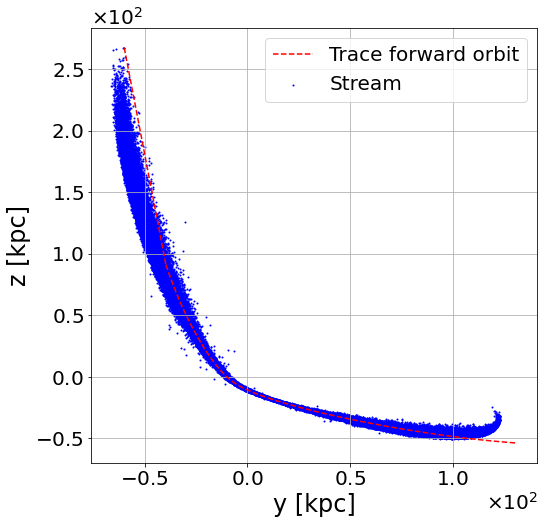

In [30]:
figtfh2, axtfh2 = plt.subplots(figsize=(8, 8))
#axtfh2 = figtfh2.add_subplot(projection='3d')

axtfh2.plot(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], color='r', 
            label='Trace forward orbit', zorder=10, linestyle='dashed')
#sc = axtfh2.scatter(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], 
#                    c=interpolated_high_vr_orbit[:, -1], cmap='spring', 
#                    label='Trace forward orbit', zorder=10, s=1)
#plt.colorbar(sc)
axtfh2.scatter(high_vr_mod_data[:, 2], high_vr_mod_data[:, 3], c='b', s=1, zorder=0, label='Stream')


axtfh2.set_xlabel('y [kpc]') #, labelpad=15)
axtfh2.set_ylabel('z [kpc]') #, labelpad=15)
#axtfh2.set_zlabel('z [kpc]', labelpad=5)
axtfh2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh2.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtfh2.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtfh2.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtfh2.legend()


plt.show()

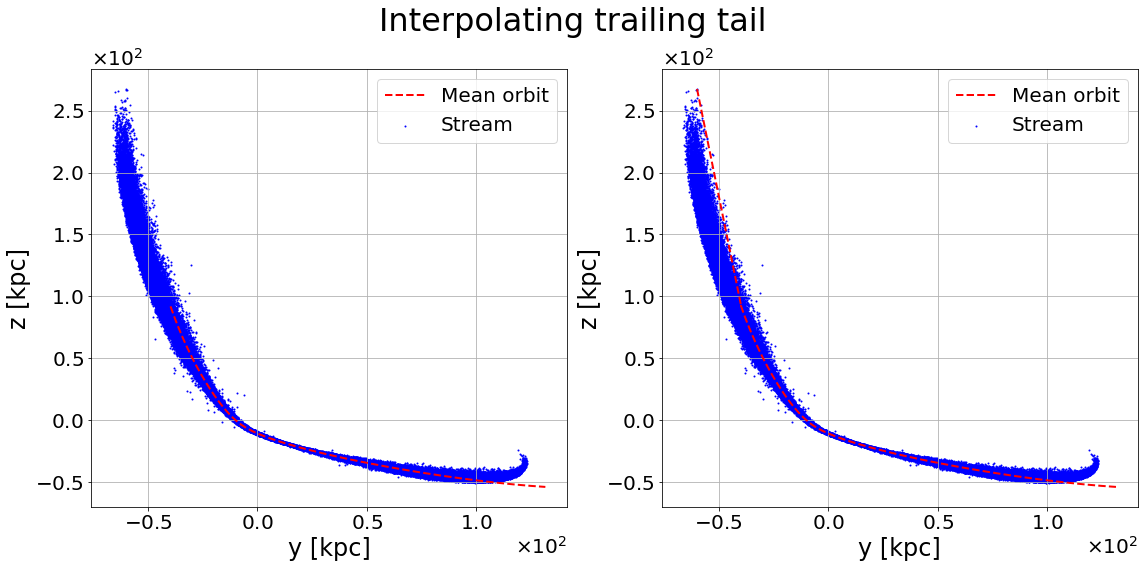

In [32]:
figtfh3, axtfh3 = plt.subplots(1, 2, figsize=(16, 8))


#high_vr_low_tstep = 900 
#high_vr_high_tstep = 1200

axtfh3[0].plot(high_vr_trace_forward_data[0, 2, high_vr_low_tstep:high_vr_high_tstep], 
           high_vr_trace_forward_data[0, 3, high_vr_low_tstep:high_vr_high_tstep], color='r', 
           label='Mean orbit', zorder=10, linestyle='dashed', lw=2)

axtfh3[0].scatter(high_vr_mod_data[:, 2], high_vr_mod_data[:, 3], c='b', s=1, zorder=0, label='Stream')


axtfh3[0].set_xlabel('y [kpc]') 
axtfh3[0].set_ylabel('z [kpc]') 
#axtfh3[0].set_title('Before interpolating trailing tail')
axtfh3[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh3[0].xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh3[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh3[0].yaxis.get_major_formatter().set_powerlimits((0, 0))

axtfh3[0].legend()





axtfh3[1].plot(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], color='r', 
            label='Mean orbit', zorder=10, linestyle='dashed', lw=2)

axtfh3[1].scatter(high_vr_mod_data[:, 2], high_vr_mod_data[:, 3], c='b', s=1, zorder=0, label='Stream')


axtfh3[1].set_xlabel('y [kpc]')
axtfh3[1].set_ylabel('z [kpc]')
#axtfh3[1].set_title('After interpolating trailing tail')
axtfh3[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh3[1].xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh3[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh3[1].yaxis.get_major_formatter().set_powerlimits((0, 0))

axtfh3[1].legend()


plt.suptitle('Interpolating trailing tail', fontsize=32)

plt.tight_layout()
plt.savefig('./Plots/Interpolating_trailing_tail_example.png', facecolor='w', bbox_inches='tight')
plt.show()

### Making animations

In [178]:
#%%time
#anim_3d(high_vr_mod_data, high_vr_mod_header, tstep=128, 
#        nsteps=39+1, lims=25.0e1, fsize=(10, 10), 
#        marker_size=1, tx=-1.5e2, ty=2.0e2, tz=2.0e2, 
#        format_type='mp4', fps=6, run='High_vr_model')

In [184]:
#anim_ComparetoTraceback(high_vr_mod_data, high_vr_trace_back_data, lims=2.5e2, 
#                        run_file='High_vr_run_and_trace_back', run_title='High vr run compared to trace back',
#                        fsize=(10, 10), fps=2, format_type='mp4')

### Streatching out stream

In [42]:
# Has columns x, y, z, vx, vy, vz
#high_vr_stream_data = high_vr_mod_data[:, 1:7, 31]
#high_vr_orbital_data = np.delete(interpolated_high_vr_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

In [63]:
#print(interpolated_high_vr_orbit[:, -1])

[0.00000000e+00 3.44974746e-01 5.17462120e-01 ... 4.32448295e+02
 4.32544373e+02 4.32544373e+02]


In [ ]:
#high_vr_aligned1 = stream_alignment_step1(high_vr_orbital_data, high_vr_stream_data)
#print('St1 DONE')
#high_vr_aligned2 = stream_alignment_step2(high_vr_orbital_data, high_vr_aligned1)
#print('St2 DONE')

In [44]:
# Saving aligned data
#np.savetxt('High_vr_aligned_data.txt', high_vr_aligned2, delimiter=',')

In [33]:
# Reading in the aligned data from file
high_vr_aligned_data = np.loadtxt('High_vr_aligned_data.txt', delimiter=',')
high_vr_orbital_data = np.delete(interpolated_high_vr_orbit, 6, axis=1)

In [34]:
high_vr_length, high_vr_width, high_vr_part_dens = stream_shape(high_vr_orbital_data, high_vr_aligned_data)
print('DONE')

DONE


In [48]:
#high_vr_variance = np.round(np.sum(high_vr_aligned1[:, -2])/len(high_vr_aligned1), 2)

#print(high_vr_variance)

In [35]:
high_vr_variance = 0.55

# Low $v_r$

In [36]:
low_vr_trace_back_data, low_vr_trace_back_header, low_vr_trace_back_extra, low_vr_trace_back_hist_data = extract_data(r'Trace_back_low_vr_run_data', r'Trace_back_low_vr', 125, 1)

print(low_vr_trace_back_data.shape)
print(low_vr_trace_back_extra.shape)
print(low_vr_trace_back_header.shape)

low_vr_trace_back_halfmass_r = low_vr_trace_back_extra[0, :]
#print(low_vr_trace_back_halfmass_r)

print(np.max(low_vr_trace_back_halfmass_r))
print(np.min(low_vr_trace_back_halfmass_r))

v_mean_low_vr_trace_back, r_mean_low_vr_trace_back = means_calc(low_vr_trace_back_header)

print(v_mean_low_vr_trace_back.shape)
print(r_mean_low_vr_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.03700917319870922
8.01049871450461e-05
(126,)
(126,)


In [29]:
#anim_3d(low_vr_trace_back_data, low_vr_trace_back_header, tstep=8, nsteps=125, lims=15.0e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=10, run='Trace_back_low_vr_run')#

## Trace forward of Boo III Orbit, 3 particles, 8Gyr forward in time

In [37]:
low_vr_trace_forward_data, low_vr_trace_forward_header, low_vr_trace_forward_extra, low_vr_trace_forward_hist_data = extract_data(r'Trace_forward_low_vr_run_data', r'Trace_forward_low_vr', 2000, 1)

print(low_vr_trace_forward_data.shape)
print(low_vr_trace_forward_extra.shape)
print(low_vr_trace_forward_header.shape)

low_vr_trace_forward_halfmass_r = low_vr_trace_forward_extra[0, :]
#print(low_vr_trace_forward_halfmass_r)

print(np.max(low_vr_trace_forward_halfmass_r))
print(np.min(low_vr_trace_forward_halfmass_r))

v_mean_low_vr_trace_forward, r_mean_low_vr_trace_forward = means_calc(low_vr_trace_forward_header)

print(v_mean_low_vr_trace_forward.shape)
print(r_mean_low_vr_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
2.453716093484886
3.692823107296476e-05
(2001,)
(2001,)


In [31]:
#anim_3d(low_vr_trace_forward_data, low_vr_trace_forward_header, tstep=4, nsteps=2000, lims=17.5e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=20, run='Trace_forward_low_vr_run')

## Low $v_r$ model run, large: 999618 particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $v_{r} = 193.7 \,$km$\,$s$^{-1}$
- $d = 46.5 \,$kpc
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [38]:
%%time
#low_vr_mod_data, low_vr_mod_header, low_vr_mod_extra, low_vr_mod_hist_data = extract_data(r'Low_vr_run_data', 
#                                                                                          r'Low_vr_run', 39, 1)


low_vr_mod_data, low_vr_mod_header, low_vr_mod_extra = extract_data_short(r'Low_vr_run_data', 
                                                                          r'Low_vr_run', 29)

in_low_vr_mod_data, in_low_vr_mod_header, in_low_vr_mod_extra = extract_data_short(r'Low_vr_run_data', 
                                                                                   r'Low_vr_run', 0)

print(low_vr_mod_data.shape)
print(low_vr_mod_extra.shape)
print(low_vr_mod_header.shape)
print(low_vr_mod_header[:, -1])

low_vr_mod_halfmass_r = low_vr_mod_extra[0, :]
print(low_vr_mod_halfmass_r)

print(np.max(low_vr_mod_halfmass_r))
print(np.min(low_vr_mod_halfmass_r))

v_mean_low_vr_mod, r_mean_low_vr_mod = means_calc(low_vr_mod_header)

print(v_mean_low_vr_mod.shape)
print(r_mean_low_vr_mod.shape)

(999618, 21, 1)
(4, 1)
(8, 1)
[ 9.99618000e+05  3.71200000e+03 -4.12737372e+00 -1.66958885e+01
  1.24435853e+01  3.52557408e+01  1.40704018e+02 -3.12718639e+02]
[0.16108165]
0.16108165165584154
0.16108165165584154
(1,)
(1,)
CPU times: user 34.5 s, sys: 1.22 s, total: 35.7 s
Wall time: 35.5 s


num_shells = 5
low_vr_core_mean_pos, low_vr_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=low_vr_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=low_vr_mod_header[2:5, 0], 
                                                       data=low_vr_mod_data)

print(np.shape(low_vr_core_mean_pos))
print(np.shape(low_vr_core_mean_size))

low_vr_core_mean_r = np.sqrt(np.sum(low_vr_core_mean_pos**2, axis=1))

figt3, axt3 = plt.subplots(figsize=(10, 8))

tsteps = np.arange(0, 40, 1)*128

axt3.plot(tsteps, fid_core_mean_r, color='m', marker='o', label='Fiducial')
axt3.scatter(tsteps[29], fid_core_mean_r[29], edgecolor='k', marker='o', s=150, linewidth=3, facecolor='none',
            zorder=20)
axt3.text(tsteps[29]-250, fid_core_mean_r[29], '29', fontsize=15)

axt3.plot(tsteps, high_vr_core_mean_r, color='b', marker='o', label='Fast')
axt3.scatter(tsteps[31], high_vr_core_mean_r[31], edgecolor='k', marker='o', s=150, linewidth=3, facecolor='none',
            zorder=20)
axt3.text(tsteps[31]-100, high_vr_core_mean_r[31]+5, '31', fontsize=15)

axt3.plot(tsteps, low_vr_core_mean_r, color='r', marker='o', label='Slow')
axt3.scatter(tsteps[29], low_vr_core_mean_r[29], edgecolor='k', marker='o', s=150, linewidth=3, facecolor='none',
            zorder=20)
axt3.text(tsteps[29]-100, low_vr_core_mean_r[29]+5, '29', fontsize=15)


axt3.set_xlabel('Time [Myr]')
axt3.set_ylabel('Distance to GC [kpc]')

axt3.legend()

plt.savefig('./Plots/Distance_from_GC_and_tsteps_vr.png', facecolor='w', bbox_inches='tight')
plt.show()

###

### Plotting snapshots

snapshots = [0, 14, 27, -1]
snapshots_plot(low_vr_mod_data, snapshots, 25.0e1, 25.0e1, (11, 20), 1, 'Low_vr_model', 
               save=False)

### Plotting orbit

tfl = trace forward low (vr)

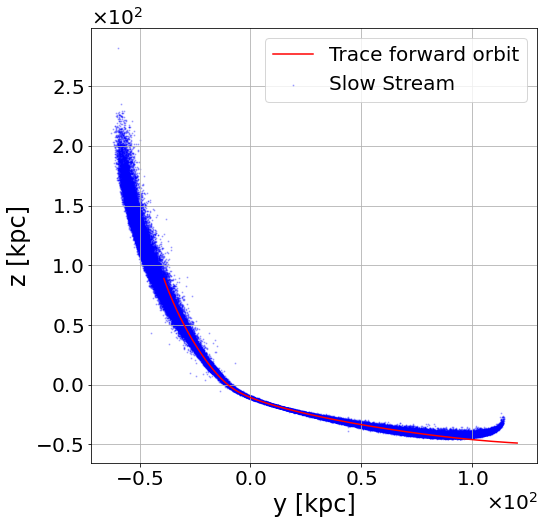

In [84]:
figtfl, axtfl = plt.subplots(figsize=(8, 8))
#axtfl = figtfl.add_subplot(projection='3d')

low_vr_low_tstep = 850
low_vr_high_tstep = 1125

axtfl.plot(low_vr_trace_forward_data[0, 2, low_vr_low_tstep:low_vr_high_tstep], 
           low_vr_trace_forward_data[0, 3, low_vr_low_tstep:low_vr_high_tstep], color='r', 
           label='Trace forward orbit', zorder=10)

axtfl.scatter(low_vr_mod_data[:, 2], low_vr_mod_data[:, 3], alpha=0.25, c='b', s=1, zorder=0, label='Slow Stream')
#axtfl.scatter(low_vr_mod_data[93697, 2], low_vr_mod_data[93697, 3], c='m', s=100, zorder=20)
#axtfl.scatter(high_vr_mod_data[:, 1, 31], high_vr_mod_data[:, 3, 31], alpha=0.25, c='b', s=1, zorder=0, label='Fast Stream')


axtfl.set_xlabel('y [kpc]') #, labelpad=15)
axtfl.set_ylabel('z [kpc]') #, labelpad=15)
#axtfhlset_zlabel('z [kpc]', labelpad=5)
axtfl.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfl.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfl.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfl.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtfl.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtfl.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtfl.legend()

plt.show()

### Constructing orbit data array for high $v_r$ model

In [85]:
low_vr_z_vals = low_vr_mod_data[:, 3]
#print(low_vr_z_vals)
low_vr_sorted_z_vals = np.sort(low_vr_z_vals, axis=0)
#print(low_vr_sorted_z_vals)
second_largest_z = low_vr_sorted_z_vals[-2]

upper_part_mask = np.where(low_vr_mod_data[:, 3] == second_largest_z)[0]
print(upper_part_mask)
# Position (x, y, z, vx, vy, vz) of highest stream particle
upper_part_pos = low_vr_mod_data[upper_part_mask, 1:7].flatten() 
upper_part_pos = np.concatenate([upper_part_pos, [1]])
print(np.shape(upper_part_pos))
# Highest orbit particle is in the first particle I include
# Getting position and velocity of highest orbit particle
upper_orb_part = low_vr_trace_forward_data[0, 1:7, low_vr_low_tstep]
upper_orb_part = np.concatenate([upper_orb_part, [1]])
print(np.shape(upper_orb_part))

low_vr_orbit_pos_extension = np.concatenate([upper_part_pos[np.newaxis, :], upper_orb_part[np.newaxis, :]], 
                                             axis=0)
print(np.shape(low_vr_orbit_pos_extension))

[93697]
(7,)
(7,)
(2, 7)


In [86]:
# Interpolate more points between these two points
for i in range(8):
        #print(i)
        # Roll particles to get x1-x2, x2-x3, etc.
        data_rolled = np.roll(low_vr_orbit_pos_extension, shift=1, axis=0) 
        
        # Delete first particle because of mismatch: xn-x1
        data = np.delete(low_vr_orbit_pos_extension, 0, axis=0) 
        data_rolled = np.delete(data_rolled, 0, axis=0)
        #print(data_rolled[:10])
        #print(data[:10])
        
        # Calculating middle point position: x, y, z
        interp_pos = (data_rolled[:, 0:3] + data[:, 0:3])/2 
        
        # Length of data with added points in between
        len_new_data = 2*len(low_vr_orbit_pos_extension)-1
        #print(len_new_data)

        # x, y, z, vx, vy, vz, t
        new_data = np.zeros((len_new_data, 7))
        
        # Adding data for new points
        new_data[0::2, :] = low_vr_orbit_pos_extension
        new_data[1::2, 0:3] = interp_pos
        new_data[1::2, 4:] = np.ones((np.shape(new_data[1::2, 4:])))
        
        low_vr_orbit_pos_extension = new_data
        

In [87]:
print(np.shape(low_vr_orbit_pos_extension))

(257, 7)


In [88]:
low_vr_orbit_position = low_vr_trace_forward_header[2:5, low_vr_low_tstep:low_vr_high_tstep].T # To get shape (N,x)
low_vr_orbit_velocity = low_vr_trace_forward_header[5:8, low_vr_low_tstep:low_vr_high_tstep].T # To get shape (N,x)
low_vr_orbit_times = low_vr_trace_forward_header[1, low_vr_low_tstep:low_vr_high_tstep].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
low_vr_orbit_data1 = np.concatenate([low_vr_orbit_position, low_vr_orbit_velocity, low_vr_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(low_vr_orbit_data1)) # Expect shape n,7


low_vr_orbit_data = np.concatenate([low_vr_orbit_pos_extension, low_vr_orbit_data1], axis=0)
print(np.shape(low_vr_orbit_data))

(275, 7)
(532, 7)


### Interpolating orbit

In [89]:
interpolated_low_vr_orbit = easy_interpolate(low_vr_orbit_data, 2)
print(np.shape(interpolated_low_vr_orbit))
#print(interpolated_low_vr_orbit[:20, 3:6])

(2125, 8)


<string>:31: RuntimeWarning: divide by zero encountered in true_divide


/tmp/ipykernel_3944243/1799275829.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc)


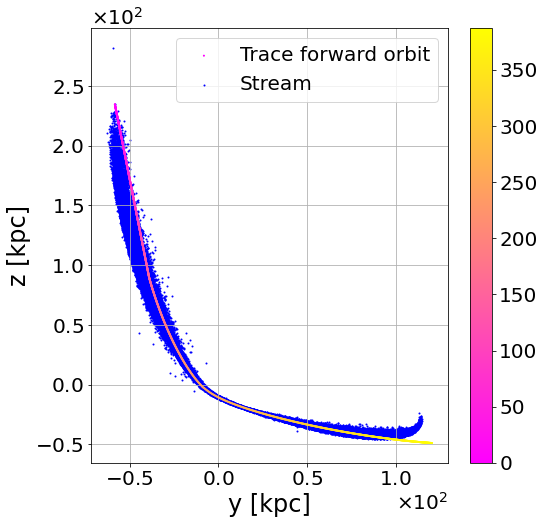

In [90]:
figtfl2, axtfl2 = plt.subplots(figsize=(8, 8))
#axtfl2 = figtfl2.add_subplot(projection='3d')

#axtfl2.plot(interpolated_low_vr_orbit[:, 1], interpolated_low_vr_orbit[:, 2], color='r', 
#            label='Trace forward orbit', zorder=10)
sc = axtfl2.scatter(interpolated_low_vr_orbit[:, 1], interpolated_low_vr_orbit[:, 2], 
                    c=interpolated_low_vr_orbit[:, -1], cmap='spring', 
                    label='Trace forward orbit', zorder=10, s=1)
plt.colorbar(sc)
axtfl2.scatter(low_vr_mod_data[:, 2], low_vr_mod_data[:, 3], c='b', s=1, zorder=0, label='Stream')


axtfl2.set_xlabel('y [kpc]') #, labelpad=15)
axtfl2.set_ylabel('z [kpc]') #, labelpad=15)
#axtfl2.set_zlabel('z [kpc]', labelpad=5)
axtfl2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfl2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfl2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfl2.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtfl2.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtfl2.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtfl2.legend()


plt.show()

### Making animations

In [180]:
#%%time
#anim_3d(low_vr_mod_data, low_vr_mod_header, tstep=128, 
#        nsteps=39+1, lims=25.0e1, fsize=(10, 10), 
#        marker_size=1, tx=-1.5e2, ty=2.0e2, tz=2.0e2, 
#        format_type='mp4', fps=6, run='Low_vr_model')

In [182]:
#anim_ComparetoTraceback(low_vr_mod_data, low_vr_trace_back_data, lims=2.5e2, 
#                        run_file='Low_vr_run_and_trace_back', run_title='Low vr run compared to trace back',
#                        fsize=(10, 10), fps=2, format_type='mp4')

### Streatching out stream

In [64]:
# Has columns x, y, z, vx, vy, vz
#low_vr_stream_data = low_vr_mod_data[:, 1:7, 29]
#low_vr_orbital_data = np.delete(interpolated_low_vr_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

In [65]:
#low_vr_aligned1 = stream_alignment_step1(low_vr_orbital_data, low_vr_stream_data)
#print('St1 DONE')
#low_vr_aligned2 = stream_alignment_step2(low_vr_orbital_data, low_vr_aligned1)
#print('St2 DONE')

Differences calculated
St1 DONE


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


St2 DONE


In [66]:
# Saving aligned data
#np.savetxt('Low_vr_aligned_data.txt', low_vr_aligned2, delimiter=',')

In [91]:
# Reading in the aligned data from file
low_vr_aligned_data = np.loadtxt('Low_vr_aligned_data.txt', delimiter=',')
low_vr_orbital_data = np.delete(interpolated_low_vr_orbit, 6, axis=1)

In [92]:
print(np.shape(low_vr_aligned_data))
#print(low_vr_aligned_data)

(999618, 9)


In [93]:
low_vr_length, low_vr_width, low_vr_part_dens = stream_shape(low_vr_orbital_data, low_vr_aligned_data)
print('DONE')

DONE


In [96]:
#print(low_vr_part_dens[200:500])

In [70]:
#low_vr_variance = np.round(np.sum(low_vr_aligned1[:, -2])/len(low_vr_aligned1), 2)

#print(low_vr_variance)

In [48]:
low_vr_variance = 0.47

In [72]:
#print(np.sum(high_vr_trace_forward_data[:, 0, 0]))
#print(np.sum(low_vr_trace_forward_data[:, 0, 0]))
#print(np.sum(fid_trace_forward_data[:, 0, 0]))

#print(np.sum(high_vr_trace_back_data[:, 0, 0]))
#print(np.sum(low_vr_trace_back_data[:, 0, 0]))
#print(np.sum(fid_trace_back_data[:, 0, 0]))

# Comparing streams

### Comparing mean orbits

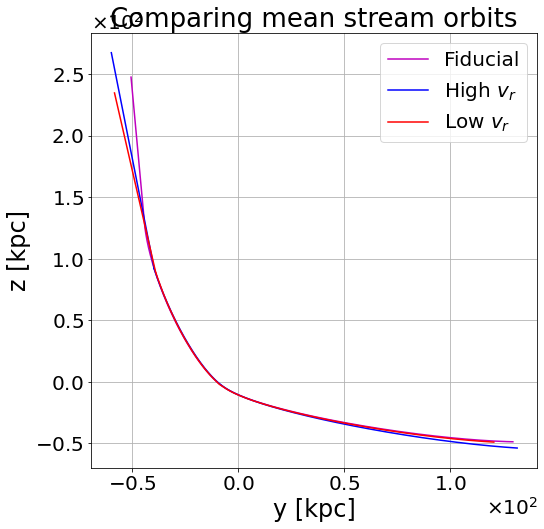

In [97]:
figc4, axc4 = plt.subplots(figsize=(8, 8))

axc4.plot(interpolated_fid_orbit[:, 1], interpolated_fid_orbit[:, 2], color='m', label='Fiducial')
axc4.plot(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], color='b', label=r'High $v_r$')
axc4.plot(interpolated_low_vr_orbit[:, 1], interpolated_low_vr_orbit[:, 2], color='r', label=r'Low $v_r$')


axc4.set_title('Comparing mean stream orbits')
axc4.set_xlabel('y [kpc]')
axc4.set_ylabel('z [kpc]')

axc4.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc4.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc4.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc4.yaxis.get_major_formatter().set_powerlimits((0, 0))


lgnd = axc4.legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[2]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_alpha(1)


plt.show()

In [98]:
fid_mid_peak_pos = np.where(fid_part_dens==np.max(fid_part_dens))[0]
#fid_mid_peak_pos = np.where(fid_aligned2[:, -1]==np.min(fid_aligned2[:, -1]))[0]
#print(fid_mid_peak_pos)
#print(np.max(fid_width))
fid_orbit_pos = np.where(fid_orbital_data==fid_aligned_data[fid_mid_peak_pos, -2])[0]
fid_mean_stream_dist = fid_orbital_data[fid_orbit_pos, -1]
fid_aligned_stream_dist = fid_aligned_data[:, -2] - fid_mean_stream_dist

high_vr_mid_peak_pos = np.where(high_vr_part_dens==np.max(high_vr_part_dens))[0]
#high_vr_mid_peak_pos = np.where(high_vr_aligned2[:, -1]==np.min(high_vr_aligned2[:, -1]))[0]
high_vr_orbit_pos = np.where(high_vr_orbital_data==high_vr_aligned_data[high_vr_mid_peak_pos, -2])[0]
high_vr_mean_stream_dist = high_vr_orbital_data[high_vr_orbit_pos, -1]
high_vr_aligned_stream_dist = high_vr_aligned_data[:, -2] - high_vr_mean_stream_dist

low_vr_mid_peak_pos = np.where(low_vr_part_dens==np.max(low_vr_part_dens))[0]
#print(low_vr_part_dens)
#print(low_vr_mid_peak_pos)
#low_vr_mid_peak_pos = np.where(low_vr_aligned2[:, -1]==np.min(low_vr_aligned2[:, -1]))[0]
low_vr_orbit_pos = np.where(low_vr_orbital_data==low_vr_aligned_data[low_vr_mid_peak_pos, -2])[0]
#print(low_vr_orbit_pos)
low_vr_mean_stream_dist = low_vr_orbital_data[low_vr_orbit_pos, -1]
low_vr_aligned_stream_dist = low_vr_aligned_data[:, -2] - low_vr_mean_stream_dist

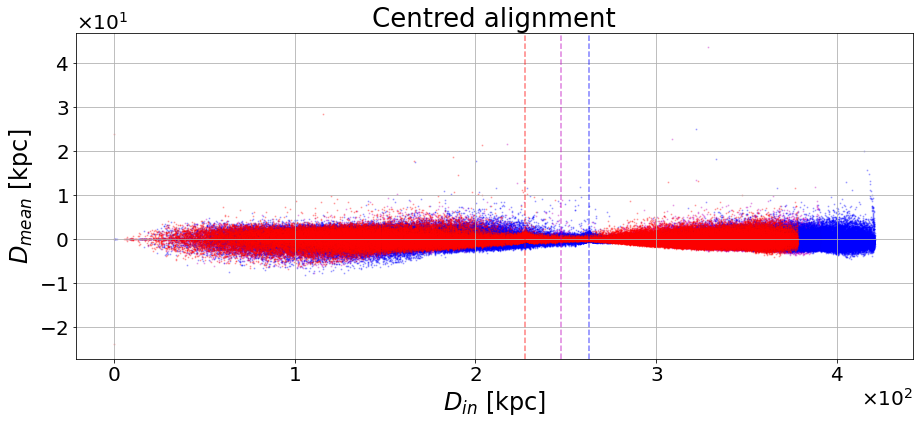

In [100]:
figc5, axc5 = plt.subplots(figsize=(15, 6))

axc5.scatter(fid_aligned_data[:, -2], fid_aligned_data[:, -1], c='m', s=1, alpha=0.25, label='Fiducial')
axc5.scatter(high_vr_aligned_data[:, -2], high_vr_aligned_data[:, -1], c='b', s=1, alpha=0.25, label='High_vr')
axc5.scatter(low_vr_aligned_data[:, -2], low_vr_aligned_data[:, -1], c='r', s=1, alpha=0.25, label='Low_vr')

axc5.axvline(fid_mean_stream_dist, color='m', alpha=0.5, linestyle='dashed')
axc5.axvline(high_vr_mean_stream_dist, color='b', alpha=0.5, linestyle='dashed')
axc5.axvline(low_vr_mean_stream_dist, color='r', alpha=0.5, linestyle='dashed')

#axc5.set_ylim(0, 95)

axc5.set_title('Centred alignment')
axc5.set_xlabel(r'$D_{in}$ [kpc]')
axc5.set_ylabel(r'$D_{mean}$ [kpc]')

axc5.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc5.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc5.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc5.yaxis.get_major_formatter().set_powerlimits((0, 0))


plt.show()

In [102]:
fid_mid_peak_pos = np.where(fid_part_dens==np.max(fid_part_dens))[0]
fid_mean_stream_dist = fid_orbital_data[fid_mid_peak_pos, -1]
fid_aligned_stream_dist = fid_aligned_data[:, -2] - fid_mean_stream_dist
fid_aligned_orb_data = fid_orbital_data[:, -1] - fid_mean_stream_dist

high_vr_mid_peak_pos = np.where(high_vr_part_dens==np.max(high_vr_part_dens))[0]
high_vr_mean_stream_dist = high_vr_orbital_data[high_vr_mid_peak_pos, -1]
high_vr_aligned_stream_dist = high_vr_aligned_data[:, -2] - high_vr_mean_stream_dist
high_vr_aligned_orb_data = high_vr_orbital_data[:, -1] - high_vr_mean_stream_dist

low_vr_mid_peak_pos = np.where(low_vr_part_dens==np.max(low_vr_part_dens))[0]
low_vr_mean_stream_dist = low_vr_orbital_data[low_vr_mid_peak_pos, -1]
low_vr_aligned_stream_dist = low_vr_aligned_data[:, -2] - low_vr_mean_stream_dist
low_vr_aligned_orb_data = low_vr_orbital_data[:, -1] - low_vr_mean_stream_dist

In [144]:
print(np.min(fid_aligned_stream_dist), np.max(fid_aligned_stream_dist))
print(np.min(low_vr_aligned_stream_dist), np.max(low_vr_aligned_stream_dist))
print(np.min(high_vr_aligned_stream_dist), np.max(high_vr_aligned_stream_dist))

-247.5422926076924 142.89224541519064
-227.58963560485319 150.74101883886357
-262.57390537095796 158.31911268932112


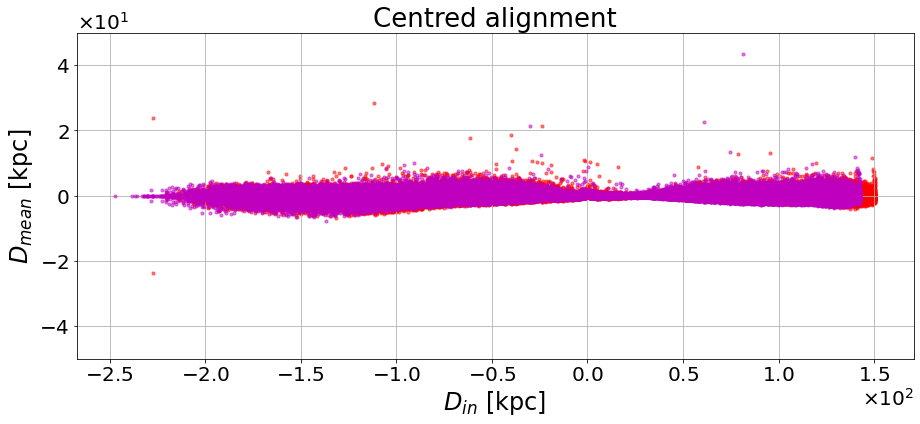

In [142]:
figc52, axc52 = plt.subplots(figsize=(15, 6)) #(15, 6)

axc52.scatter(fid_aligned_stream_dist, fid_aligned_data[:, -1], c='m', s=10, alpha=0.5, label='Fiducial', zorder=10)
#axc52.scatter(high_vr_aligned_stream_dist, high_vr_aligned_data[:, -1], c='b', s=1, alpha=0.1, label='High_vr')
axc52.scatter(low_vr_aligned_stream_dist, low_vr_aligned_data[:, -1], c='r', s=10, alpha=0.5, label='Low_vr', zorder=0)

axc52.set_title('Centred alignment')
axc52.set_xlabel(r'$D_{in}$ [kpc]')
axc52.set_ylabel(r'$D_{mean}$ [kpc]')

lims = 50

axc52.set_ylim(ymin=-lims, ymax=lims)



#axc52.scatter(fid_mod_data[:, 2, 29], fid_mod_data[:, 3, 29], c='g', alpha=0.5, s=10, label='Fiducial', 
#             zorder=10)
#axc52.scatter(high_vr_mod_data[:, 2, 31], high_vr_mod_data[:, 3, 31], c='b', alpha=0.5, s=1, label=r'Fast', 
#             zorder=0)
#axc52.scatter(low_vr_mod_data[:, 2, 29], low_vr_mod_data[:, 3, 29], c='r', alpha=0.5, s=1, label=r'Slow', 
#            zorder=20)

#axc52.set_xlabel('y [kpc]')
#axc52.set_ylabel('z [kpc]')
#axc52.legend()

axc52.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc52.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc52.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc52.yaxis.get_major_formatter().set_powerlimits((0, 0))


plt.show()

### Variance (I think)

In [105]:
print(fid_variance, high_vr_variance, low_vr_variance)

0.49 0.55 0.47


### Length

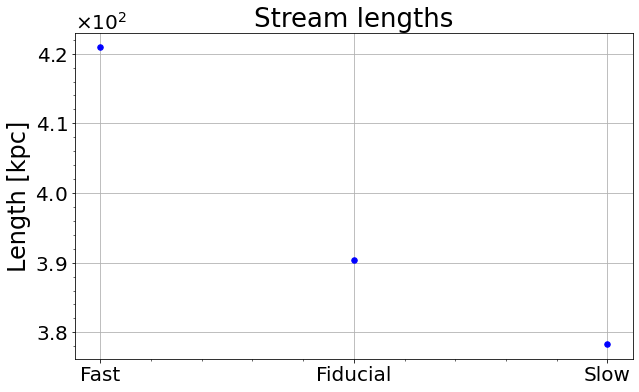

In [106]:
figc1, axc1 = plt.subplots(figsize=(10, 6))

plt.minorticks_on()

x_vals = np.array([1, 2, 3])
y_vals = np.array([high_vr_length, fid_length, low_vr_length])

labels = ["Fast", "Fiducial", "Slow"]


axc1.scatter(x_vals, y_vals, s=30, c='b', zorder=10)

axc1.set_title('Stream lengths')
axc1.set_ylabel('Length [kpc]')

axc1.set_xticks(x_vals, labels=labels)
axc1.set_xticklabels(labels, minor=False)


axc1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc1.yaxis.get_major_formatter().set_powerlimits((0, 0))

plt.grid(zorder=-10)


plt.savefig('./Plots/Length_comparisons_vr.png', facecolor='w')
plt.show()

### Width

In [125]:
print(np.shape(fid_aligned_stream_dist))
print(np.shape(fid_width))

(997967,)
(2565, 1)


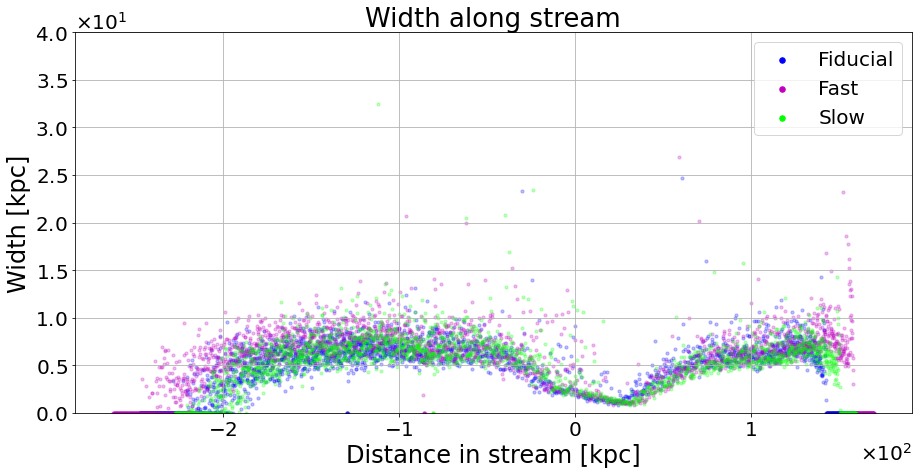

In [145]:
figc2, axc2 = plt.subplots(figsize=(15, 7))

#fid_orbital_data[:, -1]
axc2.scatter(fid_aligned_orb_data, fid_width, c='b', s=10, alpha=0.25, label='Fiducial')
axc2.scatter(high_vr_aligned_orb_data, high_vr_width, c='m', s=10, alpha=0.25, label='Fast')
axc2.scatter(low_vr_aligned_orb_data, low_vr_width, c='lime', s=10, alpha=0.25, label='Slow')


axc2.set_title('Width along stream')
axc2.set_xlabel('Distance in stream [kpc]')
axc2.set_ylabel('Width [kpc]')

axc2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc2.yaxis.get_major_formatter().set_powerlimits((0, 0))

axc2.set_ylim(ymin=0, ymax=0.4e2)


lgnd = axc2.legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[2]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_alpha(1)

#plt.savefig('./Plots/Width_along_stream_comparison_vr.png', facecolor='w')
plt.show()

In [155]:
def binned_relative_difference_vr(stream_prop, stream_data, stream_orbit_data, comp_prop, comp_data, comp_orbit_data, long_orbit_data, n_bins):
    """
    stream_prop, property of stream to compare
    
    stream_data, all data of stream
    
    comp_prop, property of comparison stream to compare
    
    comp_data, all data of comparison stream
    
    al_orbit_data, aligned orbital data for longest mean orbit
    """
    min_stream_length = np.min(long_orbit_data)
    max_stream_length = np.max(long_orbit_data)
    
    # arange for setting bin width instead of number of bins
    bin_edges = np.linspace(min_stream_length, max_stream_length, n_bins)
    
    bin_edges_rolled = np.roll(bin_edges, 1)
    bin_edges_rolled_corr = np.delete(bin_edges_rolled, 0)
    bin_edges_corr = np.delete(bin_edges, 0)
    bin_positions = (bin_edges_rolled_corr + bin_edges_corr)/2
    
    relative_difference = []
    standard_dev = []
    
    for i in range(1, len(bin_edges)):
        #bin_mask_long = (bin_edges[i-1]<=long_orbit_data)&(long_orbit_data<bin_edges[i])
        bin_mask_comp = (bin_edges[i-1]<=comp_orbit_data)&(comp_orbit_data<bin_edges[i])
        bin_mask_stream = (bin_edges[i-1]<=stream_orbit_data)&(stream_orbit_data<bin_edges[i])
        
        #bin_orbit_data_long = long_orbit_data[bin_mask_long]
        property_stream = stream_prop[bin_mask_stream]
        #print(property_stream)
        #print(f'Length in bin stream = {len(property_stream)}')
        bin_orbit_stream = stream_orbit_data[bin_mask_stream]
        
        
        property_comp = comp_prop[bin_mask_comp]
        #print(property_comp)
        #print(f'Length in bin comp stream = {len(property_comp)}')
        bin_orbit_comp = comp_orbit_data[bin_mask_comp]
        
        mean_prop_stream = np.mean(property_stream)
        #print(f'Mean stream = {mean_prop_stream}')
        mean_prop_comp = np.mean(property_comp)
        #print(f'Mean comp stream = {mean_prop_comp}')
        
        rel_diff_mean = np.abs((mean_prop_comp - mean_prop_stream)/(mean_prop_comp))
        #print(f'Rel diff = {rel_diff_mean}')
        relative_difference.append(rel_diff_mean)
        
        
        # Calculating standard deviation
        stream_std = np.std(property_stream)
        #print(f'{stream_std = }')
        comp_std = np.std(property_comp)
        #print(f'{comp_std = }')
        #print()
        
        std_den = comp_std + stream_std
        std_frac = rel_diff_mean*(std_den/(mean_prop_comp - mean_prop_stream) + std_den/mean_prop_comp)
        standard_dev.append(std_frac)
        
    relative_difference = np.array(relative_difference)
    relative_difference[np.isnan(relative_difference)] = 0
    relative_difference[np.isinf(relative_difference)] = np.max(relative_difference)
    
    standard_dev = np.array(standard_dev)
    
    result = np.concatenate([bin_positions[:, np.newaxis], relative_difference[:, np.newaxis], 
                             standard_dev[:, np.newaxis]], axis=1)
    
    return result

In [160]:
nbins=25
print(1)
diff_fid_hv = binned_relative_difference_vr(high_vr_width, high_vr_aligned_data, high_vr_aligned_orb_data, 
                                            fid_width, fid_aligned_data, fid_aligned_orb_data, 
                                            high_vr_aligned_orb_data, nbins)
#print(np.shape(diff_fid_hv))
print(2)
diff_fid_lv = binned_relative_difference_vr(low_vr_width, low_vr_aligned_data, low_vr_aligned_orb_data, 
                                            fid_width, fid_aligned_data, fid_aligned_orb_data, 
                                            fid_aligned_orb_data, nbins)
#diff_fid_lv[:, 0] = diff_fid_lv[:, 0] - 0.05e2

print(3)
diff_hv_lv = binned_relative_difference_vr(low_vr_width, low_vr_aligned_data, low_vr_aligned_orb_data, 
                                           high_vr_width, high_vr_aligned_data, high_vr_aligned_orb_data, 
                                           high_vr_aligned_orb_data, nbins)

1
2
3


/tmp/ipykernel_3944243/3048999821.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff_mean = np.abs((mean_prop_comp - mean_prop_stream)/(mean_prop_comp))
/tmp/ipykernel_3944243/3048999821.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  std_frac = rel_diff_mean*(std_den/(mean_prop_comp - mean_prop_stream) + std_den/mean_prop_comp)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(

In [148]:
#print(diff_fid_hv[:, 1], diff_fid_hv[:, 2])
#print()
#print(diff_fid_lv[:, 1], diff_fid_lv[:, 2])
#print()
#print(diff_hv_lv[:, 1], diff_hv_lv[:, 2])

In [161]:
fid_hv_infs_pos = np.argwhere(np.isinf(diff_fid_hv[:, 2])) # gives the rows
diff_fid_hv = np.delete(diff_fid_hv, fid_hv_infs_pos, axis=0)
fid_hv_nans_pos = np.argwhere(np.isnan(diff_fid_hv[:, 2])) # gives the rows
diff_fid_hv = np.delete(diff_fid_hv, fid_hv_nans_pos, axis=0)


fid_lv_infs_pos = np.argwhere(np.isinf(diff_fid_lv[:, 2])) # gives the rows
diff_fid_lv = np.delete(diff_fid_lv, fid_lv_infs_pos, axis=0)
fid_lv_nans_pos = np.argwhere(np.isnan(diff_fid_lv[:, 2])) # gives the rows
diff_fid_lv = np.delete(diff_fid_lv, fid_lv_nans_pos, axis=0)



hv_lv_infs_pos = np.argwhere(np.isinf(diff_hv_lv[:, 2])) # gives the rows
diff_hv_lv = np.delete(diff_hv_lv, hv_lv_infs_pos, axis=0)
hv_lv_nans_pos = np.argwhere(np.isnan(diff_hv_lv[:, 2])) # gives the rows
diff_hv_lv = np.delete(diff_hv_lv, hv_lv_nans_pos, axis=0)

In [179]:
diff_fid_hv[:, 1]

array([6.74608578e+01, 4.65036029e+00, 1.00651003e+00, 4.16606254e-01,
       2.60822142e-01, 2.22295636e-01, 2.50694154e-01, 2.08294270e-01,
       4.97081279e-02, 8.15167895e-02, 1.86046477e-01, 6.47303797e-02,
       2.31542329e-01, 2.12346292e-01, 9.91123782e-02, 2.35980194e-01,
       1.56338768e-01, 1.19469028e-02, 5.94502849e-02, 9.54588826e-02,
       4.56355992e-03, 1.95197349e+00])

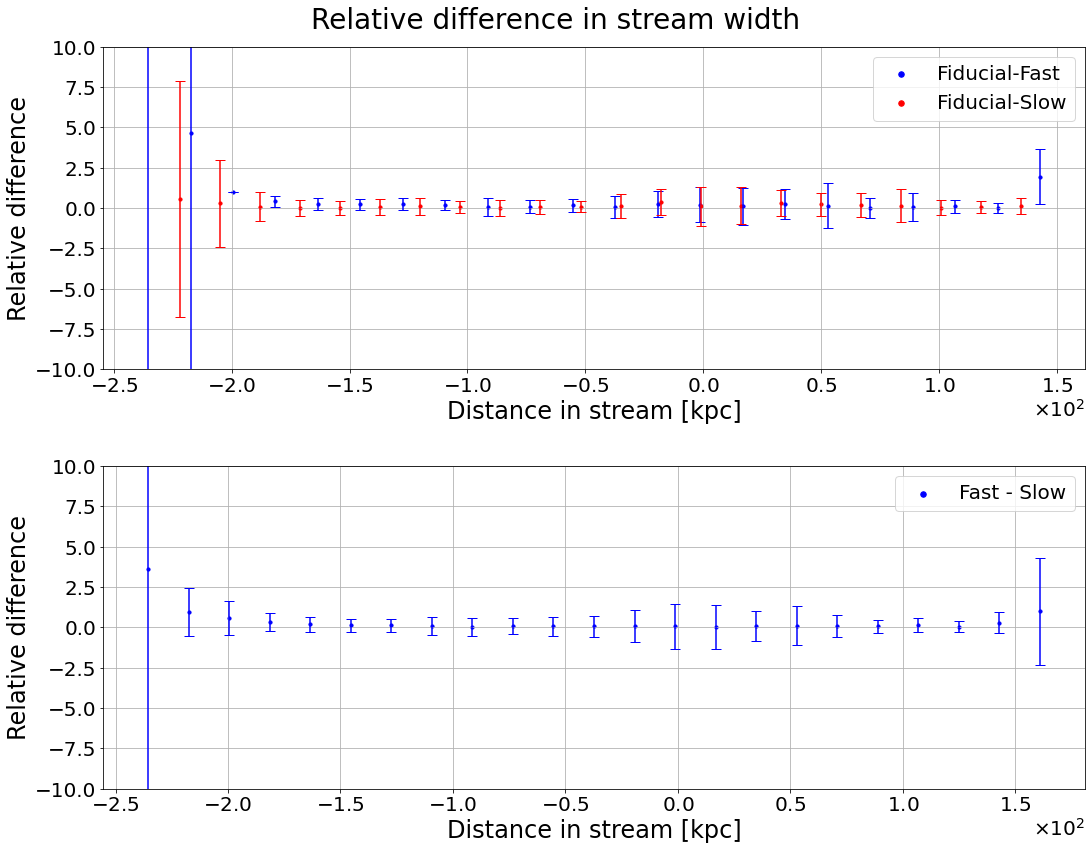

In [180]:
figc22, axc22 = plt.subplots(2, 1, figsize=(15, 12))


# Scatter plot with errorbars
# ------------------------------------------------------------------------------------
axc22[0].scatter(diff_fid_hv[:, 0], diff_fid_hv[:, 1], c='b', label='Fiducial-Fast', s=10)
axc22[0].scatter(diff_fid_lv[:, 0], diff_fid_lv[:, 1], c='r', label='Fiducial-Slow', s=10)


axc22[0].errorbar(diff_fid_hv[:, 0], diff_fid_hv[:, 1], yerr=diff_fid_hv[:, 2], ecolor='b', capsize=5, 
                 linestyle='')
axc22[0].errorbar(diff_fid_lv[:, 0], diff_fid_lv[:, 1], yerr=diff_fid_lv[:, 2], ecolor='r', capsize=5, 
                 linestyle='')

lims0 = 10

axc22[0].set_ylim(ymin=-lims0, ymax=lims0)
axc22[0].set_ylabel('Relative difference')
axc22[0].set_xlabel('Distance in stream [kpc]')

axc22[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22[0].xaxis.get_major_formatter().set_powerlimits((0, 0))


lgnd = axc22[0].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)



axc22[1].scatter(diff_hv_lv[:, 0], diff_hv_lv[:, 1], c='b', label=r'Fast - Slow', s=10)

axc22[1].errorbar(diff_hv_lv[:, 0], diff_hv_lv[:, 1], yerr=diff_hv_lv[:, 2], ecolor='b', capsize=5, linestyle='')

lims1 = 10
axc22[1].set_ylim(ymin=-lims1, ymax=lims1)
axc22[1].set_ylabel('Relative difference')
axc22[1].set_xlabel('Distance in stream [kpc]')

axc22[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22[1].xaxis.get_major_formatter().set_powerlimits((0, 0))

lgnd = axc22[1].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)

figc22.suptitle('Relative difference in stream width', fontsize=28)


plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig('./Plots/Relative_differences_width_vr.png', facecolor='w', bbox_inches='tight')
plt.show()

### Particle density

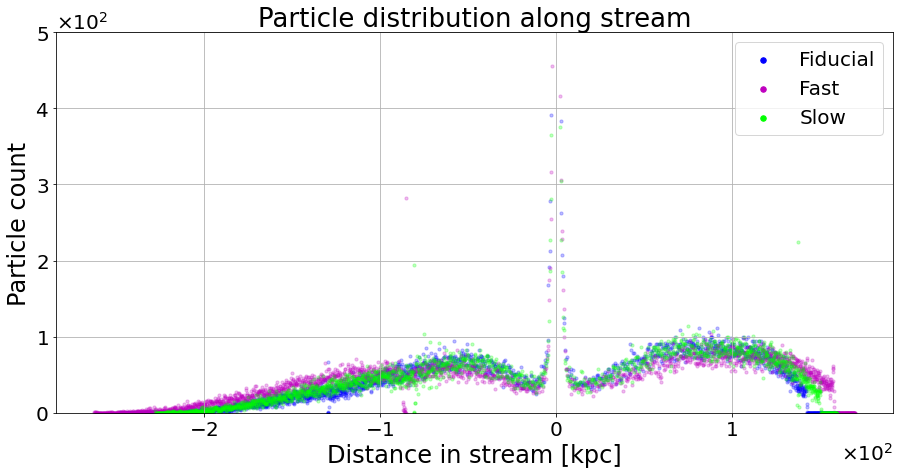

In [116]:
figc3, axc3 = plt.subplots(figsize=(15, 7))
fid_aligned_orb_data
#fid_orbital_data[:, -1]
axc3.scatter(fid_aligned_orb_data, fid_part_dens, c='b', s=10, alpha=0.25, label='Fiducial')
axc3.scatter(high_vr_aligned_orb_data, high_vr_part_dens, c='m', s=10, alpha=0.25, label='Fast')
axc3.scatter(low_vr_aligned_orb_data, low_vr_part_dens, c='lime', s=10, alpha=0.25, label='Slow')


axc3.set_title('Particle distribution along stream')
axc3.set_xlabel('Distance in stream [kpc]')
axc3.set_ylabel('Particle count')

axc3.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc3.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc3.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc3.yaxis.get_major_formatter().set_powerlimits((0, 0))

axc3.set_ylim(ymin=0, ymax=0.5e3)


lgnd = axc3.legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[2]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_alpha(1)


plt.savefig('./Plots/Particle_density_along_stream_comparison_vr.png', facecolor='w')
plt.show()

In [170]:
nbins = 25
print(1)
diff_part_dens_fid_hv = binned_relative_difference_vr(high_vr_part_dens, high_vr_aligned_data, high_vr_aligned_orb_data, 
                                                       fid_part_dens, fid_aligned_data, fid_aligned_orb_data, 
                                                       high_vr_aligned_orb_data, nbins)

print(2)
diff_part_dens_fid_lv = binned_relative_difference_vr(low_vr_part_dens, low_vr_aligned_data, low_vr_aligned_orb_data, 
                                                       fid_part_dens, fid_aligned_data, fid_aligned_orb_data, 
                                                       fid_aligned_orb_data, nbins)
#diff_part_dens_fid_lv[:, 0] = diff_part_dens_fid_lv[:, 0] - 0.05e2

print(3)
diff_part_dens_hv_lv = binned_relative_difference_vr(low_vr_part_dens, low_vr_aligned_data, low_vr_aligned_orb_data, 
                                                      high_vr_part_dens, high_vr_aligned_data, high_vr_aligned_orb_data, 
                                                      high_vr_aligned_orb_data, nbins)

1
2
3


/tmp/ipykernel_3944243/3048999821.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff_mean = np.abs((mean_prop_comp - mean_prop_stream)/(mean_prop_comp))
/tmp/ipykernel_3944243/3048999821.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  std_frac = rel_diff_mean*(std_den/(mean_prop_comp - mean_prop_stream) + std_den/mean_prop_comp)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(

In [154]:
#print(diff_part_dens_fid_hv[:, 1], diff_part_dens_fid_hv[:, 2])
#print()
#print(diff_part_dens_fid_lv[:, 1], diff_part_dens_fid_lv[:, 2])
#print()
#print(diff_part_dens_hv_lv[:, 1], diff_part_dens_hv_lv[:, 2])

In [171]:
fid_hv_part_dens_infs_pos = np.argwhere(np.isinf(diff_part_dens_fid_hv[:, 2])) # gives the rows
diff_part_dens_fid_hv = np.delete(diff_part_dens_fid_hv, fid_hv_part_dens_infs_pos, axis=0)
fid_hv_part_dens_nans_pos = np.argwhere(np.isnan(diff_part_dens_fid_hv[:, 2])) # gives the rows
diff_part_dens_fid_hv = np.delete(diff_part_dens_fid_hv, fid_hv_part_dens_nans_pos, axis=0)


fid_lv_part_dens_infs_pos = np.argwhere(np.isinf(diff_part_dens_fid_lv[:, 2])) # gives the rows
diff_part_dens_fid_lv = np.delete(diff_part_dens_fid_lv, fid_lv_part_dens_infs_pos, axis=0)
fid_lv_part_dens_nans_pos = np.argwhere(np.isnan(diff_part_dens_fid_lv[:, 2])) # gives the rows
diff_part_dens_fid_lv = np.delete(diff_part_dens_fid_lv, fid_lv_part_dens_nans_pos, axis=0)



hv_lv_part_dens_infs_pos = np.argwhere(np.isinf(diff_part_dens_hv_lv[:, 2])) # gives the rows
diff_part_dens_hv_lv = np.delete(diff_part_dens_hv_lv, hv_lv_part_dens_infs_pos, axis=0)
hv_lv_part_dens_nans_pos = np.argwhere(np.isnan(diff_part_dens_hv_lv[:, 2])) # gives the rows
diff_part_dens_hv_lv = np.delete(diff_part_dens_hv_lv, hv_lv_part_dens_nans_pos, axis=0)

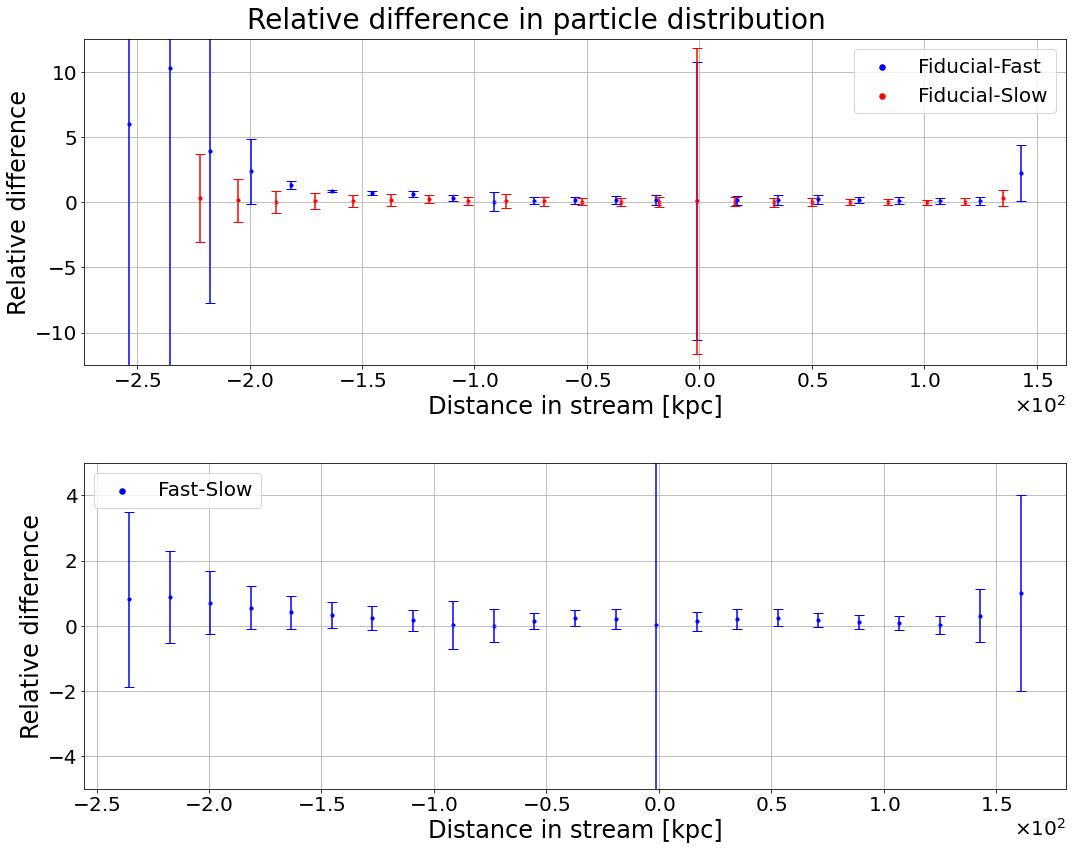

In [181]:
figc32, axc32 = plt.subplots(2, 1, figsize=(15, 12))

axc32[0].scatter(diff_part_dens_fid_hv[:, 0], diff_part_dens_fid_hv[:, 1], c='b', 
                 label='Fiducial-Fast', s=10)
axc32[0].scatter(diff_part_dens_fid_lv[:, 0], diff_part_dens_fid_lv[:, 1], c='r', 
                 label='Fiducial-Slow', s=10)

axc32[0].errorbar(diff_part_dens_fid_hv[:, 0], diff_part_dens_fid_hv[:, 1], yerr=diff_part_dens_fid_hv[:, 2], 
                  ecolor='b', capsize=5, linestyle='')
axc32[0].errorbar(diff_part_dens_fid_lv[:, 0], diff_part_dens_fid_lv[:, 1], yerr=diff_part_dens_fid_lv[:, 2], 
                  ecolor='r', capsize=5, linestyle='')


lims0 = 12.5
axc32[0].set_ylim(ymin=-lims0, ymax=lims0)
axc32[0].set_ylabel('Relative difference')
axc32[0].set_xlabel('Distance in stream [kpc]')

axc32[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32[0].xaxis.get_major_formatter().set_powerlimits((0, 0))


lgnd = axc32[0].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)



axc32[1].scatter(diff_part_dens_hv_lv[:, 0], diff_part_dens_hv_lv[:, 1], c='b', label='Fast-Slow', s=10)


axc32[1].errorbar(diff_part_dens_hv_lv[:, 0], diff_part_dens_hv_lv[:, 1], yerr=diff_part_dens_hv_lv[:, 2], 
                  ecolor='b', capsize=5, linestyle='')

lims1 = 5
axc32[1].set_ylim(ymin=-lims1, ymax=lims1)
axc32[1].set_ylabel('Relative difference')
axc32[1].set_xlabel('Distance in stream [kpc]')

axc32[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32[1].xaxis.get_major_formatter().set_powerlimits((0, 0))

lgnd = axc32[1].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)

figc32.suptitle('Relative difference in particle distribution', fontsize=28)


plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig('./Plots/Relative_differences_particle_density_vr.png', facecolor='w', bbox_inches='tight')
plt.show()